In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
bank = pd.read_csv('datasets/bank.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
bank['y'] = bank['y'].replace({'yes':1,'no':0})

In [4]:
bank['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
                      , [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)

In [5]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
bank.describe()

,age,balance,day,month,duration,campaign,pdays,previous,y
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,40.991924,1410.637517,15.913936,6.176050,264.544301,2.806876,39.670974,0.544070,0.115828
std,10.505378,3010.612091,8.216673,2.374798,260.642141,3.129682,99.934062,1.702219,0.320056
min,19.000000,-3313.000000,1.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,67.000000,9.000000,5.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,440.000000,16.000000,6.000000,186.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1464.000000,21.000000,8.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,12.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


In [7]:
bank.describe(include='O')

,job,marital,education,default,housing,loan,contact,poutcome
count,4334,4334,4334,4334,4334,4334,4334,4334
unique,12,3,3,2,2,2,3,4
top,management,married,secondary,no,yes,no,cellular,unknown
freq,942,2680,2306,4261,2476,3650,2801,3555


In [8]:
bank['y'].value_counts()

y
0    3832
1     502
Name: count, dtype: int64

In [9]:
X = bank.drop(['y'], axis=1)
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,10,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,5,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,4,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,6,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,5,226,1,-1,0,unknown


In [10]:
y = bank['y']

In [11]:
ohe = OneHotEncoder()
ohe = ohe.fit(X[['job','marital','education','default','housing','loan','contact','poutcome']])
X_ohe = ohe.transform(X[['job','marital','education','default','housing','loan','contact','poutcome']])

In [12]:
X_ohe_new = X_ohe.toarray()
X_ohe_new

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]], shape=(4334, 31))

In [13]:
ohe.get_feature_names_out(['job','marital','education','default','housing','loan','contact','poutcome'])

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'default_no', 'default_yes', 'housing_no', 'housing_yes',
       'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

In [14]:
X_ohe_df = pd.DataFrame(X_ohe_new, columns=ohe.get_feature_names_out(['job','marital','education','default','housing','loan','contact','poutcome']))
X_ohe_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [15]:
X_new = pd.concat([X[['age', 'balance', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous']],X_ohe_df],axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [17]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [18]:
print("The R2:", model.score(X_new, y)*100, '%')
print("The Training R2:", model.score(X_train, y_train)*100, '%')
print("The Training R2:", model.score(X_test, y_test)*100, '%')

The R2: 96.88509460083064 %
The Training R2: 100.0 %
The Training R2: 89.62336664104535 %


In [19]:
y_pred = model.predict(X_test)

In [20]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1123   31]
 [ 104   43]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1154
           1       0.58      0.29      0.39       147

    accuracy                           0.90      1301
   macro avg       0.75      0.63      0.67      1301
weighted avg       0.88      0.90      0.88      1301



In [21]:
probs = model.predict_proba(X_test)

In [22]:
scores = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

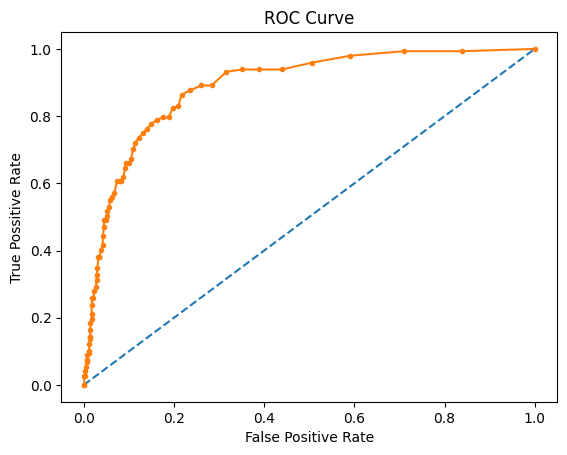

In [23]:
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Possitive Rate")
plt.show()

In [24]:
auc(fpr, tpr)

0.8896119973119231